In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from neural_net import NeuralNetwork
from matplotlib import pyplot as plt
import numpy as np


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X, y = X.astype(int), np.array(y, dtype=int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

scaler = StandardScaler()
pca = PCA(n_components=300) 

X_train_proc = scaler.fit_transform(X_train)
X_test_proc = scaler.transform(X_test)
X_train_proc = pca.fit_transform(X_train_proc)
X_test_proc = pca.transform(X_test_proc)


param_grid = {      
    'eta': [0.01],         
    'batch_size': [128],           
    'max_iter': [2000],
    'activation': ['tanh'], 
}

model = NeuralNetwork(
    random_state=1,
    eta = 0.01,
    batch_size = 64,
    max_iter = 50,
    activation= 'relu',
    layers =[256, 128], 
    verbose= 1,
    val_jump=1,
    tol=1e-4,
    early_stopping=True
)

sk_model = MLPClassifier(
    random_state=1,
    learning_rate_init= 0.01,
    batch_size=64,
    max_iter=50,
    activation= 'relu',
    hidden_layer_sizes=[256,128],
    validation_fraction=0.1,
    early_stopping=True,
    tol=1e-4
)

rs = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    n_iter=1,
    verbose=2,
    n_jobs=None 
)

# model = rs.fit(X_train_proc, y_train).best_estimator_
# print(f"Best:\n{rs.best_params_}")
print("My NeuralNet..")
model = model.fit(X_train_proc, y_train)
print("Scikit-learn MLP..")
sk_model = sk_model.fit(X_train_proc, y_train)

C:\Users\Booma\anaconda3\envs\book_env\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


My NeuralNet..
epoch    0 loss 0.38881 - val_loss 0.37311
epoch    1 loss 0.47298 - val_loss 0.28345
epoch    2 loss 0.06264 - val_loss 0.24535
epoch    3 loss 0.12468 - val_loss 0.22461
epoch    4 loss 0.05507 - val_loss 0.20873
epoch    5 loss 0.15197 - val_loss 0.20701
epoch    6 loss 0.11976 - val_loss 0.19250
epoch    7 loss 0.12127 - val_loss 0.18315
epoch    8 loss 0.02804 - val_loss 0.18085
epoch    9 loss 0.09115 - val_loss 0.17544
epoch   10 loss 0.14494 - val_loss 0.17547
epoch   11 loss 0.19048 - val_loss 0.17047
epoch   12 loss 0.12989 - val_loss 0.16868
epoch   13 loss 0.01869 - val_loss 0.16956
epoch   14 loss 0.03779 - val_loss 0.16581
epoch   15 loss 0.15084 - val_loss 0.16503
epoch   16 loss 0.01412 - val_loss 0.16425
epoch   17 loss 0.01734 - val_loss 0.16323
epoch   18 loss 0.00569 - val_loss 0.16046
epoch   19 loss 0.06794 - val_loss 0.16208
epoch   20 loss 0.01670 - val_loss 0.16142
epoch   21 loss 0.01019 - val_loss 0.15969
epoch   22 loss 0.01958 - val_loss 0.15

In [18]:
from mlxtend.evaluate import mcnemar_table, mcnemar
from visualization import Visualizer, plot_training_history, conf, ROC, plot_precision_recall, plot_benchmark_metrics

In [15]:
classifiers = {
    "Extensible MLP": model,
    "Scikit-Learn MLP": sk_model
}

Saved plot to Output\benchmark_roc.png


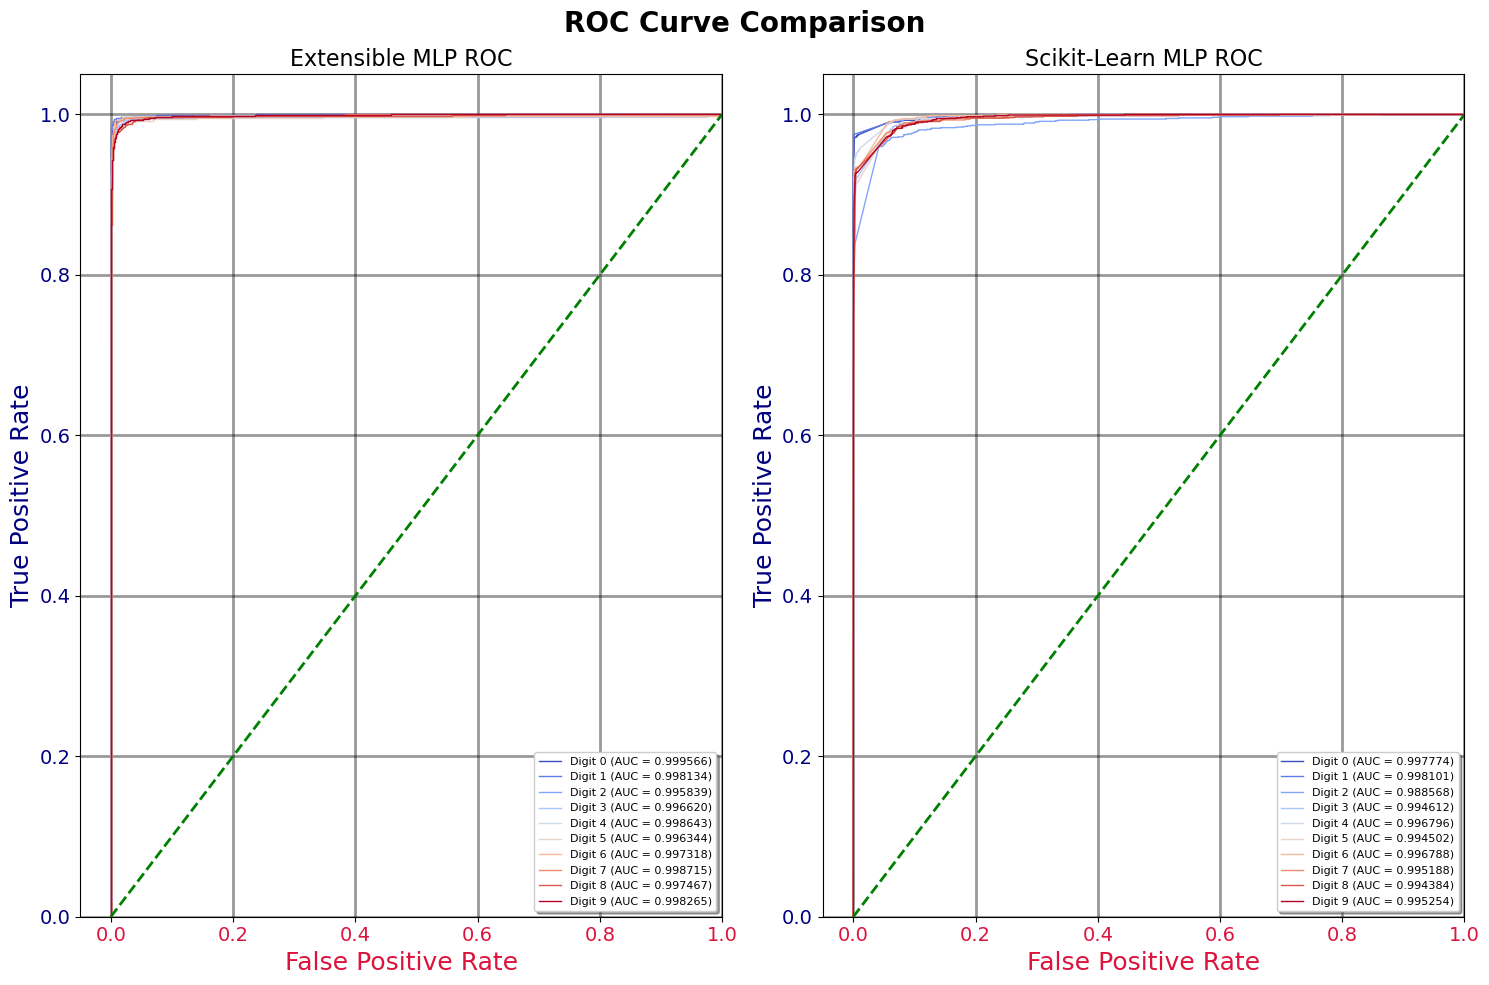

In [3]:
Visualizer.plot_grid(classifiers, ROC, X_test_proc, y_test, shape=(1, 2), title="ROC Curve Comparison", save_path='Output\\benchmark_roc.png')

Saved plot to Output\benchmark_conf.png


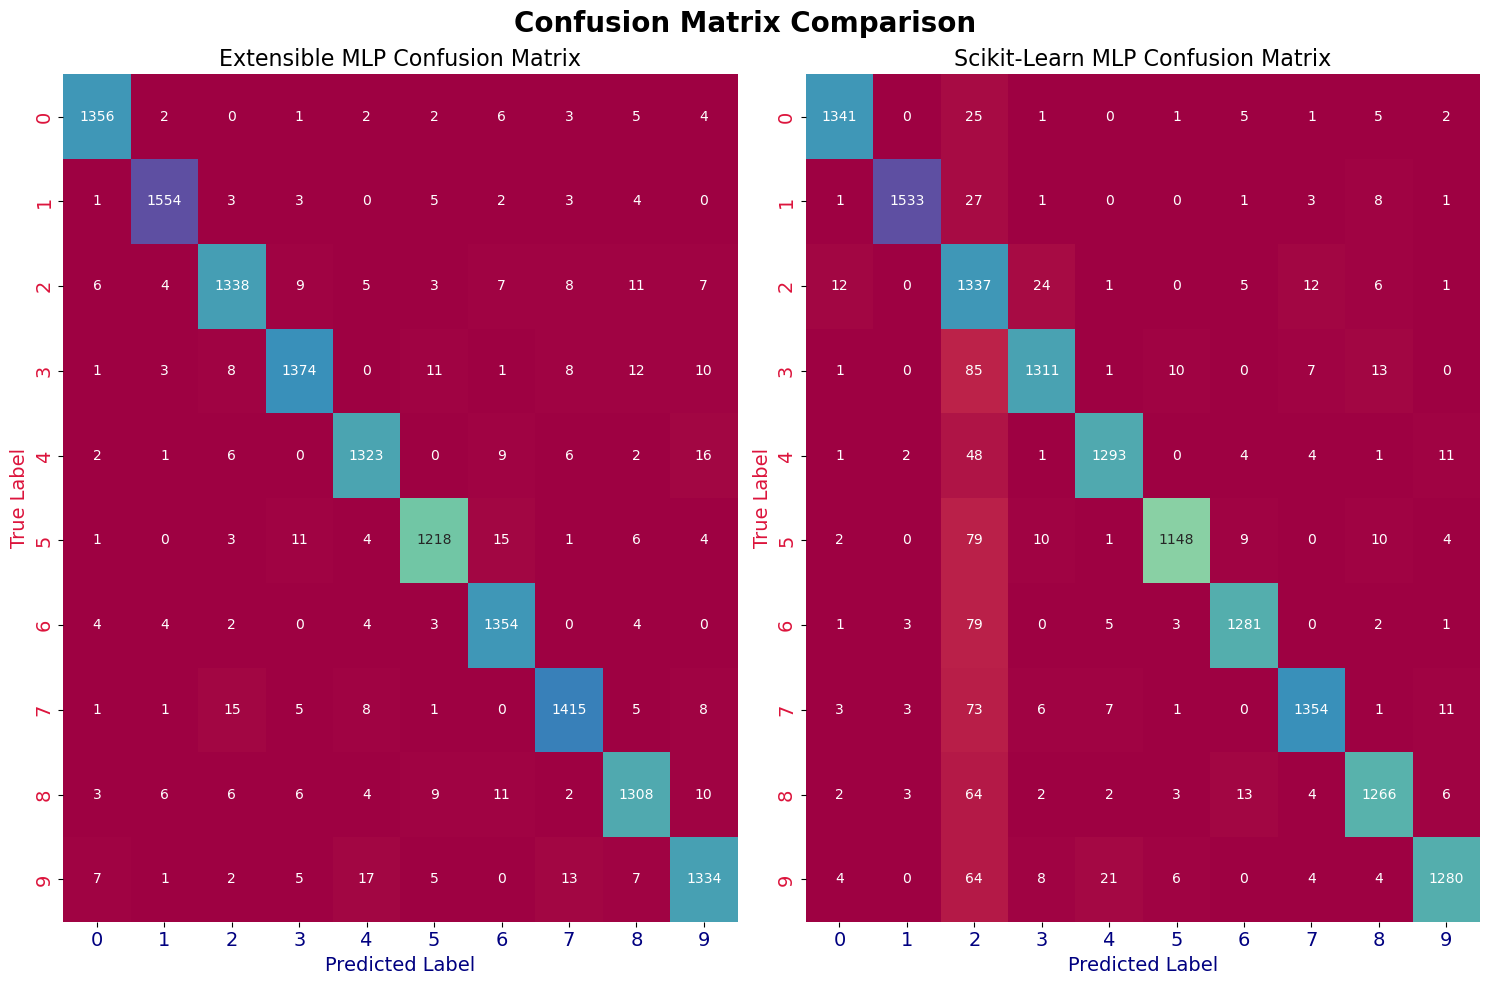

In [4]:
Visualizer.plot_grid(classifiers, conf, X_test_proc, y_test, shape=(1, 2), title="Confusion Matrix Comparison", save_path='Output\\benchmark_conf.png')

Saved plot to Output\benchmark_precision_recall.png


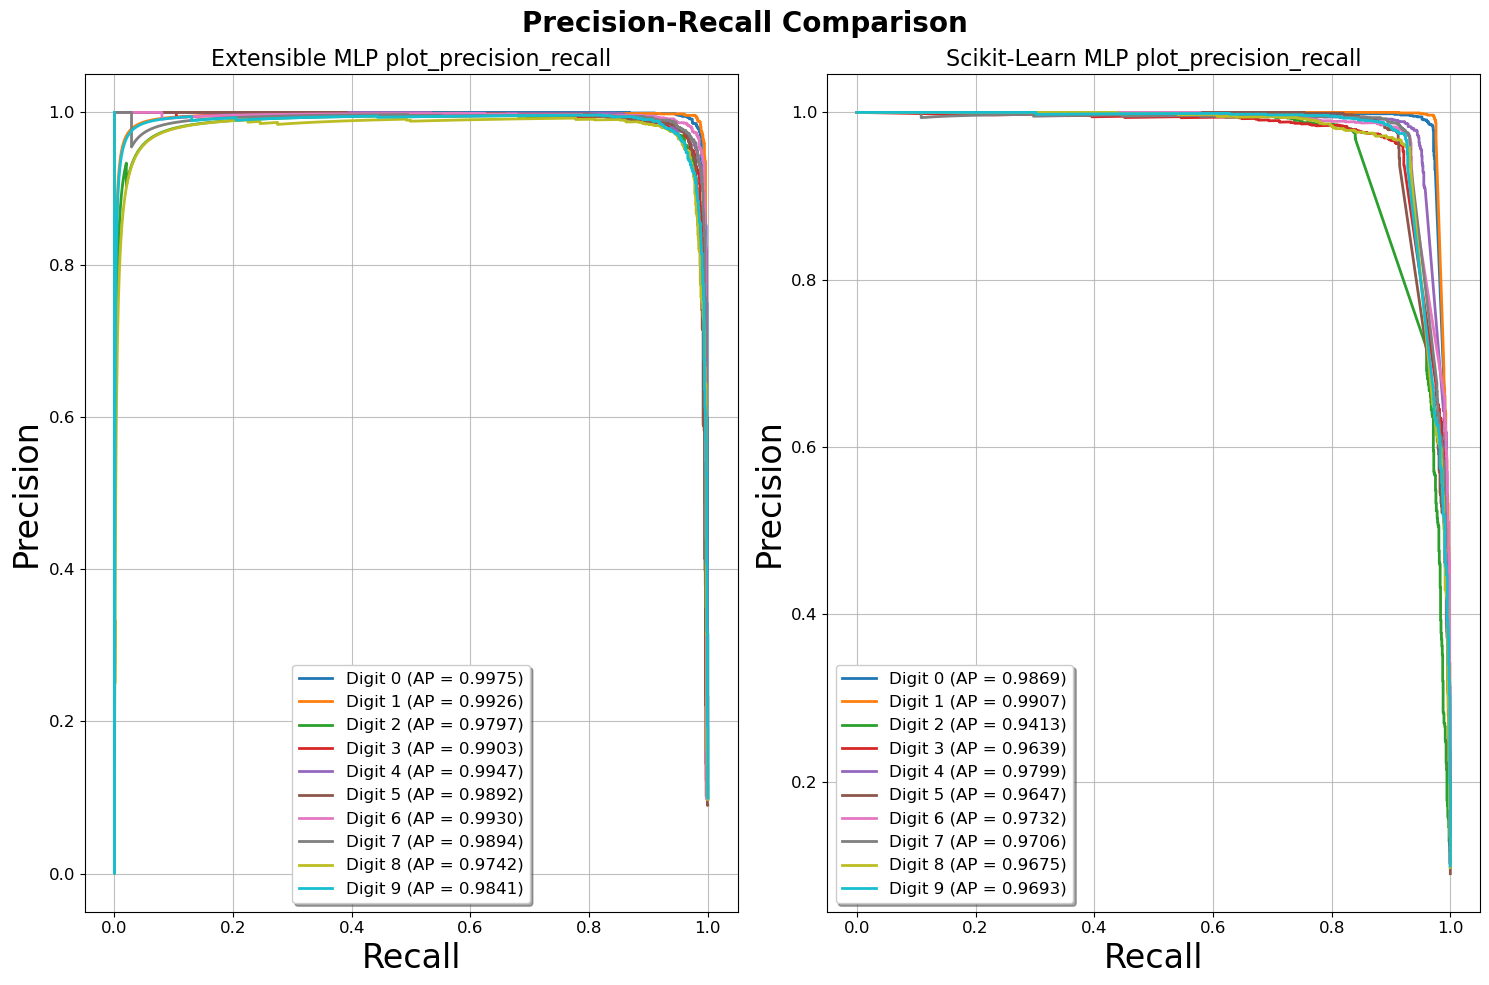

In [5]:
Visualizer.plot_grid(classifiers, plot_precision_recall, X_test_proc, y_test, shape=(1, 2), title="Precision-Recall Comparison", save_path='Output\\benchmark_precision_recall.png')

In [19]:
y_pred_my= model.predict(X_test_proc)
y_pred_sklearn = sk_model.predict(X_test_proc) 

tb = mcnemar_table(y_target=y_test, 
                   y_model1=y_pred_my, 
                   y_model2=y_pred_sklearn)

chi2, p = mcnemar(ary=tb, corrected=True)

my_wins = tb[0,1]
sklearn_wins =tb[1,0]
print(f"McNemar's Test Results:")
print(f"Chi-squared: {chi2:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("Conclusion: No significant statistical difference between the models (Null Hypothesis retained).")
else:
    print("Conclusion: Significant difference found (Null Hypothesis rejected).")

if my_wins > sklearn_wins:
    diff = my_wins - sklearn_wins
    print(f"My model is better by {diff} cases.")
elif sklearn_wins > my_wins:
    diff = sklearn_wins - my_wins
    print(f"Scikit-learn MLP is better by {diff} cases.")
else:
    print(f"It's a tie.")

McNemar's Test Results:
Chi-squared: 249.3780
p-value: 0.0000
Conclusion: Significant difference found (Null Hypothesis rejected).
My model is better by 430 cases.


Saved plot to Output\benchmark_metrics.png


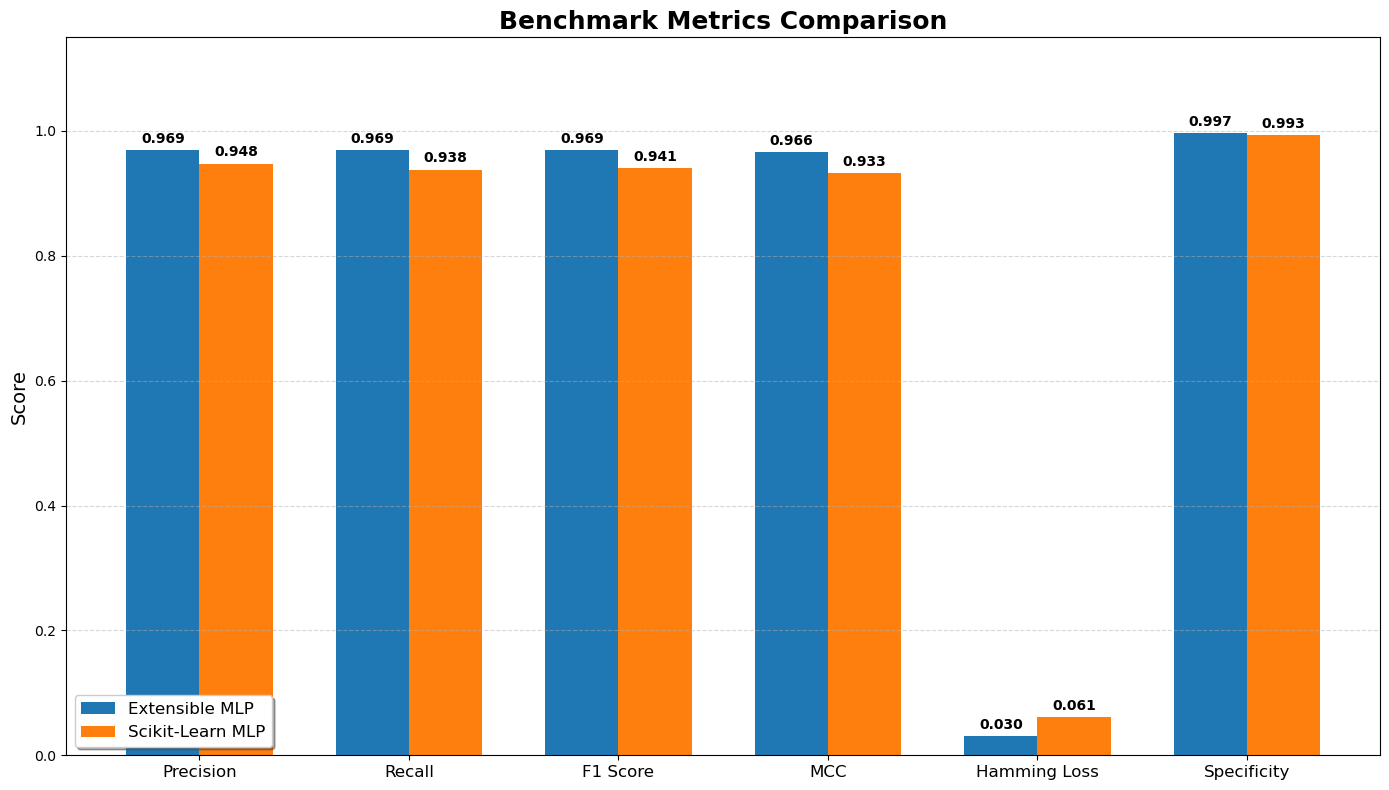

In [20]:
plot_benchmark_metrics(classifiers, X_test_proc, y_test, save_path='Output\\benchmark_metrics.png')

In [7]:
from visualization import plot_training_history
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef

y_pred = model.predict(X_test_proc)
perf_NN = (f"\
    \nAccuracy: [{accuracy_score(y_test, y_pred):.4f}], \
    Precision: [{precision_score(y_test, y_pred, average='weighted'):.4f}], \
    Recall: [{recall_score(y_test, y_pred, average='weighted'):.4f}], \
    F1: [{f1_score(y_test, y_pred, average='weighted'):.4f}], \
    MCC: [{matthews_corrcoef(y_test, y_pred):.4f}]")
print(perf_NN)

    
Accuracy: [0.9696],     Precision: [0.9696],     Recall: [0.9696],     F1: [0.9696],     MCC: [0.9662]


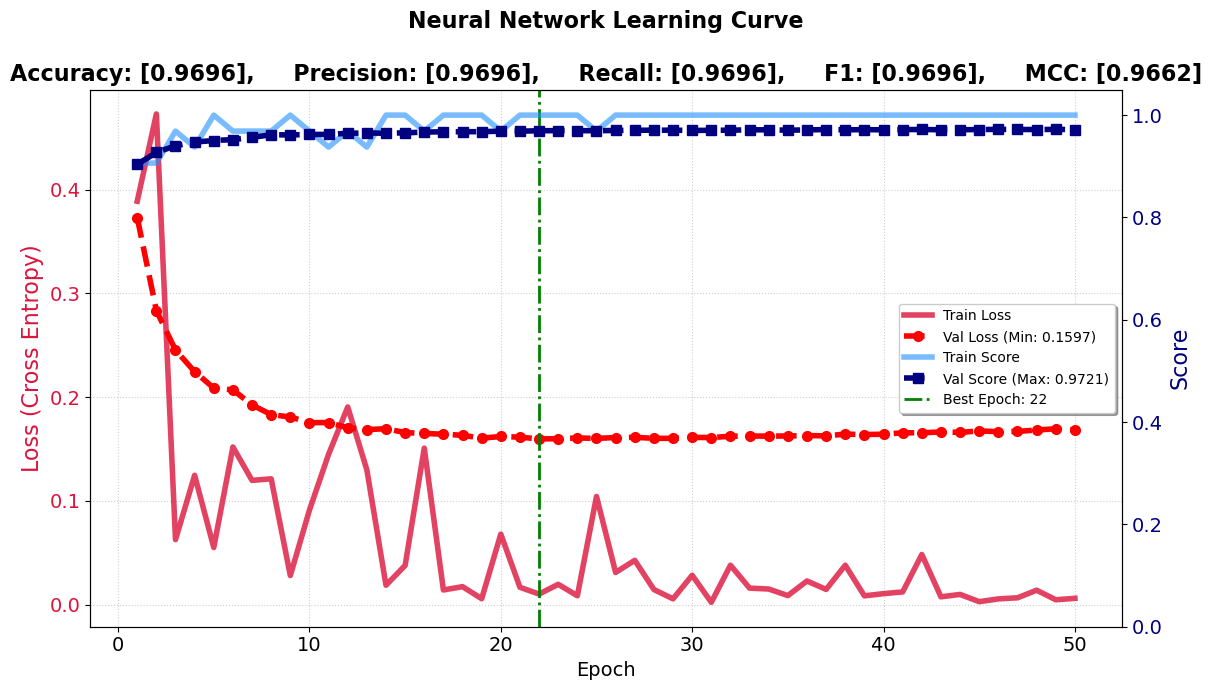

In [8]:
clf = model
plot_training_history(clf, scope=1, title="Neural Network Learning Curve\n" + perf_NN)

In [9]:
y_pred = sk_model.predict(X_test_proc)
perf_sk = (f"\
    \nAccuracy: [{accuracy_score(y_test, y_pred):.4f}], \
    Precision: [{precision_score(y_test, y_pred, average='weighted'):.4f}], \
    Recall: [{recall_score(y_test, y_pred, average='weighted'):.4f}], \
    F1: [{f1_score(y_test, y_pred, average='weighted'):.4f}], \
    MCC: [{matthews_corrcoef(y_test, y_pred):.4f}]")
print(perf_sk)

    
Accuracy: [0.9389],     Precision: [0.9479],     Recall: [0.9389],     F1: [0.9412],     MCC: [0.9327]


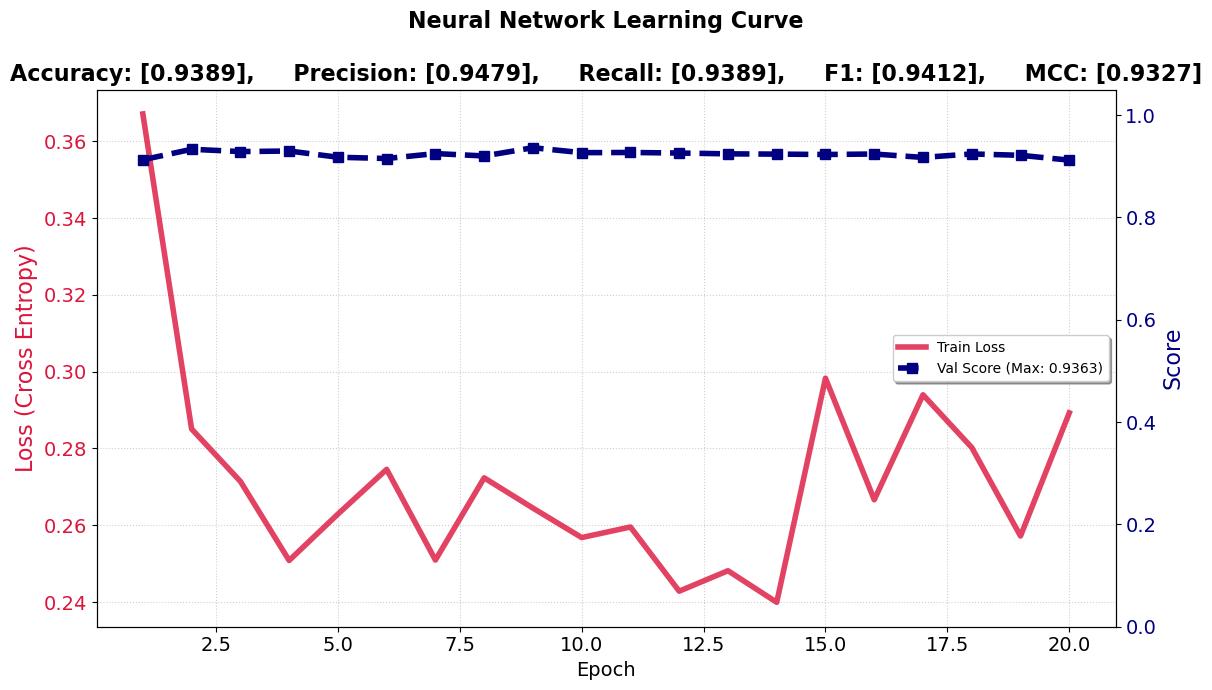

In [10]:
clf = sk_model
plot_training_history(clf, scope=1, title="Neural Network Learning Curve\n" + perf_sk)

In [11]:
offset=0
y_score = sk_model.predict_proba(X_test_proc)

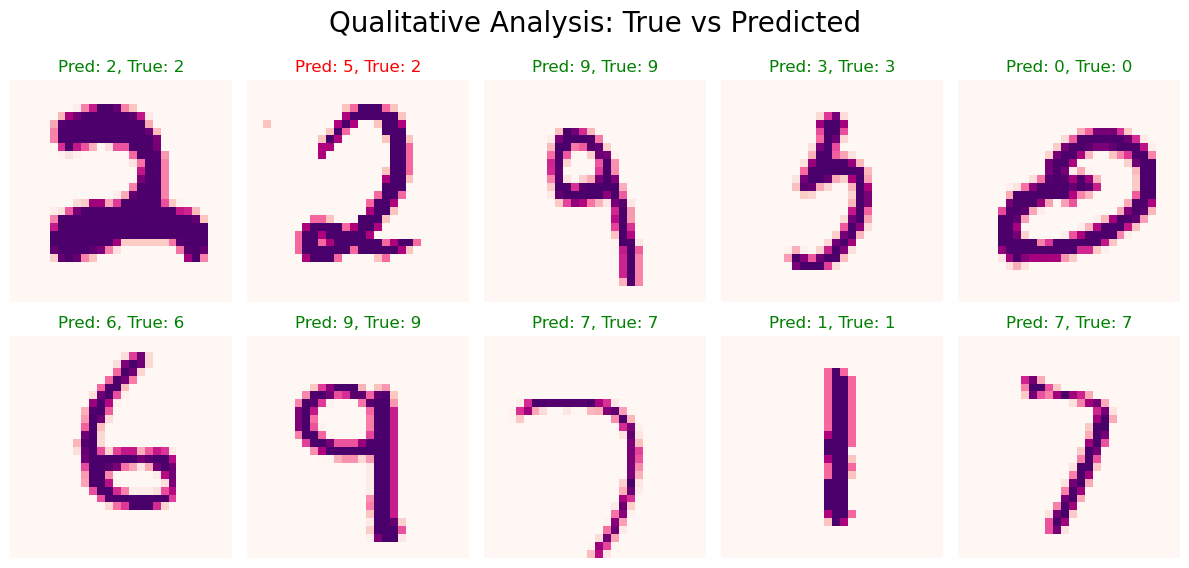

In [25]:
num_samples = 10
confidences = np.max(y_score, axis=1)
indices = np.random.choice(len(X_test_proc), num_samples, replace=False) # random sample
# indices = np.argsort(confidences)[::-1][offset:offset +num_samples] # most confidence predictions 
# indices = np.argsort(confidences)[offset:offset +num_samples] # least confidence predictions 
offset += num_samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Qualitative Analysis: True vs Predicted', fontsize=20)
for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = X_test[idx].reshape(28, 28)

    pred = model.predict(X_test_proc[idx].reshape(1, -1))[0]
    true = y_test[idx]

    ax.imshow(img, cmap='RdPu')
    ax.set_title(f"Pred: {pred}, True: {true}",
                 color=('green' if pred == true else 'red'))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
offset=0
y_score = model.predict_proba(X_test_proc)

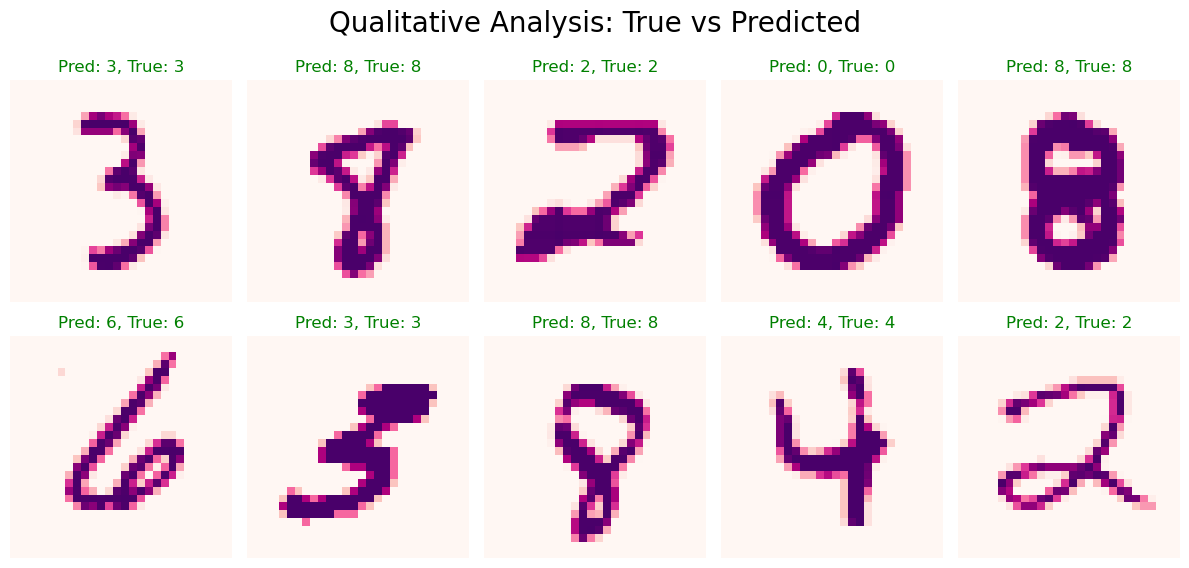

In [28]:
num_samples = 10
confidences = np.max(y_score, axis=1)
indices = np.random.choice(len(X_test_proc), num_samples, replace=False) # random sample
# indices = np.argsort(confidences)[::-1][offset:offset +num_samples] # most confidence predictions 
# indices = np.argsort(confidences)[offset:offset +num_samples] # least confidence predictions 
offset += num_samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Qualitative Analysis: True vs Predicted', fontsize=20)
for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = X_test[idx].reshape(28, 28)

    pred = model.predict(X_test_proc[idx].reshape(1, -1))[0]
    true = y_test[idx]

    ax.imshow(img, cmap='RdPu')
    ax.set_title(f"Pred: {pred}, True: {true}",
                 color=('green' if pred == true else 'red'))
    ax.axis('off')

plt.tight_layout()
plt.show()